<a href="https://colab.research.google.com/github/mmattyg/Calligraphic-Trajectories/blob/master/Generating_Calligraphic_Trajectories_with_Model_Predictive_Control_(MPC).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
!git clone https://github.com/mmattyg/Calligraphic-Trajectories.git

Cloning into 'Calligraphic-Trajectories'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 8 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (8/8), done.


In [53]:
#@title setup
%matplotlib inline
import numpy as np
import scipy as sp
from scipy.linalg import sqrtm, expm
import sympy as sym
import matplotlib.pyplot as plt
import _pickle as cPickle
import os
from functools import reduce

# https://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
plt.style.use('fivethirtyeight') #fivethirtyeight') #seaborn-poster') #seaborn-poster')
# More customiztions here:
# http://matplotlib.org/users/customizing.html
# Other customizations
import matplotlib as mpl
label_size = 12
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.titlesize'] = 'medium'
mpl.rcParams['axes.labelsize'] = 12 #u'large' # 12 #'medium'
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['font.size']  = 12

# Default 2d plot setup
def plt_setup(axis=True):
    # save it for later
    plt.axis('equal')
    if not axis:
        plt.axis('off')
    plt.gca().invert_yaxis()

def load_pkl(data_path):
    with open(os.path.expanduser(data_path), "rb") as f:
        raw_data = cPickle.load(f)
    return raw_data

# Some utilities hidden for space considerations
def latex(v, name=''):
    s = '$$' + name + '='
    if v.ndim == 3:
        n = v.shape[2]
        s += '\\left['
        for i in range(n):
            s += sym.latex(sym.Matrix(v[:,:,i]))
            if i < n-1:
                s += ','
        s += '\\right]'
    else:
        s += sym.latex(sym.Matrix(v))
    s += '$$'
    return s

def plot_gauss(Mu, Sigma, color=[0.,0.7,1.],alpha=0.5,linewidth=1,markersize=6, scale=1., colors=[]):
    ''' Adapted from pyPBDlib This function displays the parameters of a Gaussian Mixture Model (GMM).

     Inputs -----------------------------------------------------------------
       o  Mu: D x K array representing the centers of K Gaussians.
       o Sigma: D x D x K array representing the covariance matrices of K Gaussians.

     Author:    Martijn Zeestraten, 2015
             http://programming-by-demonstration.org/martijnzeestraten

             Note- Daniel Berio, switched matrix layout to be consistent with pbdlib matlab,
                   probably breaks with gmm now.
    '''
    if (Mu.ndim ==1):
        nbVar    = Mu.shape[0]
        nbStates = 1
        # Fix size of arrays:
        Mu = Mu.reshape(1,nbVar)
        Sigma = Sigma.reshape(1,nbVar,nbVar)
    else:
        nbStates = Mu.shape[1]  
        nbVar    = Mu.shape[0]

    nbDrawingSeg = 35;    
    t = np.linspace(-np.pi, np.pi, nbDrawingSeg);    
                                                                                               
    if not colors:
        colors=[color for i in range(nbStates)]

    for i in range(0,nbStates):
        # Create Polygon
        R = np.real(sqrtm(scale*Sigma[:,:,i]))
        points = R.dot(np.array([[np.cos(t)], [np.sin(t)]]).reshape([2,nbDrawingSeg])) + Mu[:,i].reshape([2,1])
        polygon = plt.Polygon(points.transpose().tolist(),facecolor=colors[i],alpha=alpha,linewidth=linewidth)
                                                                                                   
        # Set properties
        #polygon.set_alpha(0.3)
        #polygon.set_color(color)        
                                                                                                                                                                           
        plt.gca().add_patch(polygon)                     # Patch
        l,= plt.plot(Mu[0,i], Mu[1,i], '.', color=colors[i])    # Mean
        plt.plot(points[0,:], points[1,:], color=colors[i], linewidth=linewidth, alpha=alpha*2., markersize=markersize) # Contour
    
    return l

def deriv(X, dt, n=1):
    ''' Does not return same size array,
    but works better for high order derivs.'''
    ''' n'th order derivative '''
    Dx = X
    for i in range(n):
        Dx = np.diff(Dx, axis=1)/dt 
    return Dx

def norm(X):
    if X.ndim < 2:
        return np.linalg.norm(X)
    return np.sqrt(np.sum(X**2, axis=0))

# multiply multiple matrices, still ugly but better than nested np.dot's
mul = lambda mats: reduce(np.dot, mats)

# Configuration
cfg = lambda: None
cfg.fig_w = 7
cfg.fig_h = 5
cfg.figsize = (cfg.fig_w, cfg.fig_h)
cfg.plan_color = [0.5, 0.5, 0.5]

#%%

In [32]:
#@title Dynamic sytem
import numpy as np

class DynSys:
    def __init__(self, order, dt=0.01, dim=2):
        self.order = order
        self.dim = dim
        self.dt = dt

        ## construct system matrices
        # continuous single
        A = np.zeros((order,order))
        A[0:order-1, 1:order] = np.eye(order-1)
        B = np.zeros((order,1))
        B[-1,:] = 1.

        # Euler discretization
        A = np.eye(A.shape[0]) + A * dt
        B = B * dt

        # Multiple output
        # Add dimensions
        A = np.kron(A, np.eye(dim))
        B = np.kron(B, np.eye(dim) )

        # Sensor matrix (assuming only position is observed) 
        # Actually unused here and directly setting unobserved Q entries to 0 weight
        C = np.kron( np.hstack([np.ones((1,1)), np.zeros((1, order-1))]),
                    np.eye(dim))
        
        self.A, self.B, self.C = A, B, C
        
    def y(self, x):
        ''' y = Cx'''
        return np.dot(self.C, x)
    
    def num_timesteps(self, duration):
        return int(duration/self.dt)

    def matrices(self):
        return self.A, self.B

sys = DynSys(2)
latex(sys.A,'\\bm{A}'), latex(sys.B, '\\bm{B}'), latex(sys.C,'\\bm{C}') # show latex


('$$\\bm{A}=\\left[\\begin{matrix}1.0 & 0.0 & 0.01 & 0.0\\\\0.0 & 1.0 & 0.0 & 0.01\\\\0.0 & 0.0 & 1.0 & 0.0\\\\0.0 & 0.0 & 0.0 & 1.0\\end{matrix}\\right]$$',
 '$$\\bm{B}=\\left[\\begin{matrix}0.0 & 0.0\\\\0.0 & 0.0\\\\0.01 & 0.0\\\\0.0 & 0.01\\end{matrix}\\right]$$',
 '$$\\bm{C}=\\left[\\begin{matrix}1.0 & 0.0 & 0.0 & 0.0\\\\0.0 & 1.0 & 0.0 & 0.0\\end{matrix}\\right]$$')

In [33]:
#@title batch solution
def batch_mpc(sys, MuQ, Q, r, compute_covariance=False):
    A, B = sys.matrices()
    order, dim = sys.order, sys.dim
    
    n = MuQ.shape[1]
    cDim = order*dim
    
    # Scaling helps avoiding numerical issues in lest squares estimation
    maxv = np.max(Mu)
    scale = 1e-6 / maxv 
    scale2 = scale*scale
    MuQ = MuQ * scale
    # scale weights (quadratic)
    r = r / scale2
    # here we skip the derivative terms (diagonal) of the last block of Q
    # since we will set it to enforce a zero end condition
    Q[:-cDim+dim,:-cDim+dim] = Q[:-cDim+dim,:-cDim+dim] / scale2

    # stack Mu's into one large vector
    Xi_hat = np.reshape(MuQ.T, (MuQ.shape[0]*MuQ.shape[1], 1)) 

    # Control cost matrix
    R = np.kron( np.eye(n-1),
                np.eye(dim) * r )

    # Sx and Su matrices for batch LQR
    Su = np.zeros((cDim*n, dim*(n-1)))
    Sx = np.kron( np.ones((n,1)),
                  np.eye(dim*order) )
    M = np.array(B)
    for i in range(1, n):
        Sx[ i*cDim:n*cDim, : ] = mul( [Sx[ i*cDim:n*cDim, : ], A] )        
        Su[ i*cDim:(i+1)*cDim, 0:i*dim ] = M 
        M = np.hstack([ mul([A, M[:, 0:dim]]), M ])

    # Initial condition given by first mean
    x0 = MuQ[:,0].reshape(-1,1)

    # Damped least squares estimate
    SuInvSigmaQ = mul([Su.T, Q])

    Rq = mul([SuInvSigmaQ, Su]) + R
    rq = mul([SuInvSigmaQ, Xi_hat - mul([Sx, x0]) ] )

    # damped least squares solution
    u = np.linalg.solve(Rq,rq)
    x = np.reshape( mul([Sx, x0]) + mul([Su, u]), (n, cDim)).T
    u = np.reshape( u, (n-1, dim) ).T
    
    # unscale
    x = x/scale
    u = u/scale

    if compute_covariance:
        Cov = mul([Su, inv(Rq), Su.T]) / scale2
        # Need to check this, also feel that directly specifying sigma is more intuitive
        mse = 1. # (np.abs( mul([Xi_hat.T, Q, Xi_hat]) - mul([rq.T, inv(Rq), rq]) )[0] / (sys.dim*MuQ.shape[1]))  
        return x, Cov, mse
    
    return x

In [34]:
#@title Iterative (Riccati) implementation, less efficient
from numpy.linalg import inv, pinv

# This implementation of the augmented iterative version is for demonstration purposes
# (as described in the paper).
# A much more efficient solution is to augment the covariances before the whole weight 
# vector Q is created, which will not require the double matrix inversions (see aug_q sub-function).
def iterative_mpc_augmented(sys, MuQ, Q, r):
    A, B = sys.matrices()
    order, dim = sys.order, sys.dim
    
    n = MuQ.shape[1]
    
    cDim = order*dim
    
    Xi_hat = MuQ 
    Xi_aug = np.vstack([Xi_hat, np.ones(n)])
    pinv = np.linalg.pinv

    def aug_q(i):
        Qi = Q[i*cDim:(i+1)*cDim, i*cDim:(i+1)*cDim]
        Xi_i = Xi_hat[:,i].reshape(-1,1)
        return pinv(np.vstack([ np.hstack([pinv(Qi) + mul([Xi_i, Xi_i.T]), Xi_i]),
                             np.hstack([Xi_i.T, np.eye(1)]) ]))
    # augment system matrices
    A_ = A
    A = np.eye(cDim+1)
    A[:cDim, :cDim] = A_
    B = np.vstack([B, np.zeros(dim)])

    # Control cost matrix
    R = np.eye(dim) * r

    P = np.zeros((cDim+1, cDim+1, n))
    i = n-1
    P[ :, :, -1] = aug_q(i) 
    
    d = np.zeros((cDim, n))
    # Riccati recursion
    pinv = np.linalg.pinv
    for i in range(n-2, 0, -1):
        Qi = aug_q(i)         
        P[:,:,i] = Qi - mul([ A.T, 
                            mul([ P[:,:,i+1], B, inv( mul([ B.T, P[:,:,i+1], B ]) + R), 
                                  B.T, 
                                  P[:,:,i+1] ]) - P[:,:,i+1], A])
    
    # Initial condition given by first mean
    x0 = Xi_aug[:,0].reshape(-1,1)

    x = np.zeros((cDim+1, n))
    u = np.zeros((dim, n))

    x_t = x0[:,0]

    for i in range(n):
        x[:,i] = x_t
        p = P[:, :, i]
        mu = Xi_aug[:, i]
        
        G = mul([ pinv( mul([B.T, p, B]) + R ), B.T ])
        # feedback gain
        K = mul([ G, p, A ])
        # Control command (highest order derivative of system)
        #u[:,i] = mul([ K, mu - x_t ]) + M
        u[:,i] = mul([-K, x_t])
        # New state
        x_t = mul([A, x_t]) + mul([B, u[:,i]])

    return x[0:cDim,:]

def iterative_mpc(sys, MuQ, Q, r):
    A, B = sys.matrices()
    order, dim = sys.order, sys.dim

    n = MuQ.shape[1]
    cDim = order*dim

    Xi_hat = MuQ 
    Xi_aug = np.vstack([Xi_hat, np.ones(n)])
 
    # Control cost matrix
    R = np.eye(dim) * r

    P = np.zeros((cDim, cDim, n))
    i = n-1
    P[ :, :, -1] = Q[i*cDim:, i*cDim:]
    
    d = np.zeros((cDim, n))
    # Riccati recursion
    pinv = np.linalg.pinv
    for i in range(n-2, 0, -1):
        # Not so fun to write this with NumPy
        Qi = Q[i*cDim:(i+1)*cDim, i*cDim:(i+1)*cDim]
        
        P[:,:,i] = Qi - mul([ A.T, 
                            mul([ P[:,:,i+1], B, inv( mul([ B.T, P[:,:,i+1], B ]) + R), 
                                  B.T, 
                                  P[:,:,i+1] ]) - P[:,:,i+1], A])
        
        d[:,i] = ( mul([ A.T - mul([ A.T, P[:,:,i+1], B, inv(R + mul([ B.T, P[:,:,i+1], B ]) ), B.T ]), 
                       mul([ P[:,:,i+1], mul([ A, Xi_hat[:, i] ]) - Xi_hat[:, i+1] ]) + d[:,i+1]]) )
        
    # Initial condition given by first mean
    x0 = MuQ[:,0].reshape(-1,1)

    x = np.zeros((cDim, n))
    u = np.zeros((dim, n))

    x_t = x0[:,0]

    for i in range(n):
        x[:,i] = x_t
        p = P[:, :, i]
        mu = Xi_hat[:, i]
        
        G = mul([ pinv( mul([B.T, p, B]) + R ), B.T ])
        
        # feedback gain
        K = mul([ G, p, A ])
        # Feedforward term
        M = mul([ -G, mul([p, mul([A, mu]) - mu]) + d[:,i] ])
        # Control command (highest order derivative of system)
        u[:,i] = mul([ K, mu - x_t ]) + M
        # New state
        x_t = mul([A, x_t]) + mul([B, u[:,i]])

    return x

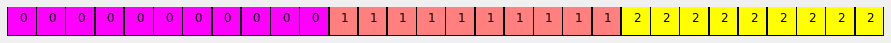

In [35]:
#@title reference trajectories
def stepwise(m, n):
    T = range(n)
    I = np.linspace(0, float(m)-0.1, n).astype(int)
    return I, T

# For 30 time steps and 3 via points:
Ts = np.ones(30).astype(int)
I, T = stepwise(3, 30)
Ts[T] = I

plt.figure(figsize=(14,0.5))
plt.gca().pcolormesh([[ t if t >= 0 else '.' for t in Ts]], cmap='spring', edgecolor='k')
for i, t in enumerate(Ts):
    plt.text(0.4 + i, 0.5,str(t))
plt.axis('off')
plt.show()

This will allow us to control the trajectory evolution through the manipulation of the covariances of each Gaussian. The tracking reference and weight matrices (in terms of precision) for the whole trajectory are then computed with

In [36]:
#@title make reference
def make_reference(Mu, Sigma, n, sys, reference=stepwise, end_weight = 1e10):
    ''' Make reference and state cost matrices'''
    order, dim = sys.order, sys.dim
    cDim = order*dim
    muDim = Mu.shape[0]
    m = Mu.shape[1]
    
    # precision matrices
    Lambda = np.zeros((muDim, m*muDim))
    for i in range(m):
        Lambda[:,i*muDim:muDim*(i+1)] = np.linalg.inv(Sigma[:,:,i])

    Q = np.zeros((cDim*n, cDim*n)) # Precision matrix
    MuQ = np.zeros((cDim, n))

    I, T = reference(m, n) # Get reference indices
    for i, t in zip(I, T):
        Q[ t*cDim:t*cDim+muDim, t*cDim:t*cDim+muDim] = Lambda[:,i*muDim:(i+1)*muDim] 
        MuQ[:muDim, t] = Mu[:,i]

    # end indices (forces movement to a stop with higher order systems)
    ind = T[-1]
    if end_weight > 0.0: # and muDim <= dim:
        for i in range(muDim, cDim):
            Q[ind*cDim+i, ind*cDim+i] = end_weight
    return MuQ, Q

Load a pickle sequence of \(5\) Gaussians for the letter "M"

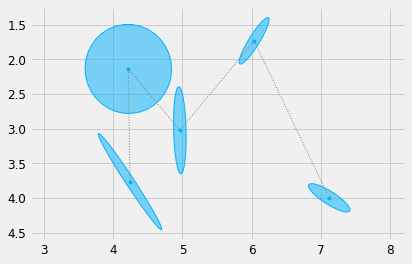

In [54]:
import matplotlib.pyplot as plt
import pickle

def new_load_pkl(data_path):
    with open(data_path, 'rb') as pickle_file:
        raw_data = pickle.load(pickle_file, encoding='latin1')
    return raw_data

def load_gauss(path, scale=1.): 
    Mu, Sigma = new_load_pkl(path)
    Mu *= scale
    Sigma *= scale**2
    return Mu, Sigma

Mu, Sigma = load_gauss('/content/Calligraphic-Trajectories/m_1.pkl', scale=0.01) 

# Plot it
plt.figure()
plot_gauss(Mu, Sigma)
plt.plot(Mu[0,:], Mu[1,:], ':', color=cfg.plan_color, linewidth=1.)
#plt.plot(Mu[0,:], Mu[1,:], 'ro')
plt_setup()
plt.show()

Generate trajectory to track the gaussians:

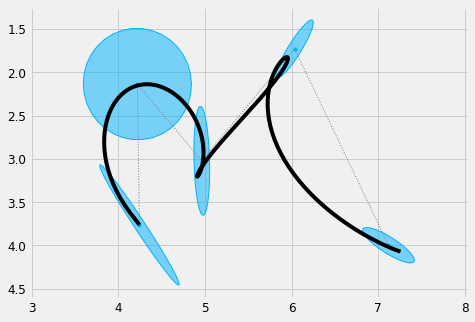

In [55]:
order = 4
duration = Mu.shape[1]*0.2 # 0.2 seconds per state
sys = DynSys(order, dt=0.005)
n = sys.num_timesteps(duration)
endw = 1e10
r = 1e-10 # Regularisation 
MuQ, Q = make_reference(Mu, Sigma, n, sys, reference=stepwise, end_weight=1e10) 
x = iterative_mpc(sys, MuQ, Q, r=r)
y = sys.y(x)

# plot it
plt.figure(figsize=cfg.figsize)
plot_gauss(Mu, Sigma)
plt.plot(Mu[0,:], Mu[1,:], ':', color=cfg.plan_color, linewidth=1.)
plt.plot(y[0,:], y[1,:], 'k')
plt_setup()
plt.show()

We can see the smoothing effect of the regularisation parameter \(r\) by increasing its value

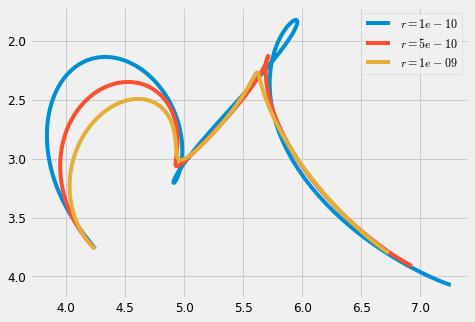

In [56]:
plt.figure(figsize=cfg.figsize)
#plot_gauss(Mu, Sigma)
#plt.plot(Mu[0,:], Mu[1,:], ':', color=cfg.plan_color, linewidth=1.)

for r in [1e-10, 5e-10, 10e-10]: #, 15e-10]: #np.linspace(1e-10, 1e-13, 5):
    x = iterative_mpc(sys, MuQ, Q, r=r)
    y = sys.y(x)
    plt.plot(y[0,:], y[1,:], label='$r=' + str(r) + '$')
plt_setup()
plt.legend()
plt.show()

On the other hand, the behavior of this parameter will vary greatly across different system orders, which may be impractical for experimentation purposes.

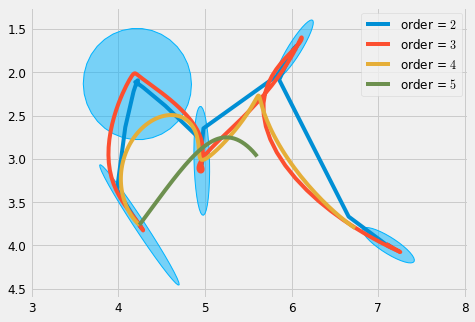

In [57]:
plt.figure(figsize=cfg.figsize)

r = 1e-9
plot_gauss(Mu, Sigma)
for order in range(2, 6):
    sys = DynSys(order, dt=0.005)
    MuQ, Q = make_reference(Mu, Sigma, n, sys, reference=stepwise, end_weight=1e10) #1e-15) #0.)
    x = iterative_mpc(sys, MuQ, Q, r=r)
    y = sys.y(x)
    plt.plot(y[0,:], y[1,:], label='order = $' + str(order) + '$')
plt.legend()

plt_setup()
plt.savefig('r_scaling.pdf')
plt.show()

We can improve on this by specifying the regularisation through a maximum displacement parameter \(d\), which is can be computed based on the the low frequency gain of the system, where the frequency is chosen to be the period of an oscillatory motion between two targets. This can be computed with

In [58]:
def SHM_r(d, order, duration, m):
    ''' simple harmonic motion based scale factor,
        computes the control cost r in terms of maximum allowed displacement'''
    period = (duration/(m-1))
    omega = (2. * np.pi) / period
    return 1. / ((d * omega**order)**2)

and produces results that are more consistent across orders, and thus easier to control.
Note that in this case, **decreasing** the parameter \(d\) produces a smoothing effect on the trajectory.

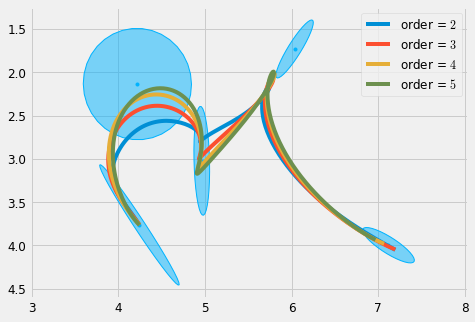

In [59]:
plt.figure(figsize=cfg.figsize)
d = 0.15
plot_gauss(Mu, Sigma)
for order in range(2, 6):
    sys = DynSys(order, dt=0.005)
    n = sys.num_timesteps(duration)
    MuQ, Q = make_reference(Mu, Sigma, n, sys, reference=stepwise, end_weight=1e10) #1e-15) #0.)
    r = SHM_r(d, order, duration, Mu.shape[1])
    x = iterative_mpc(sys, MuQ, Q, r=r)
    y = sys.y(x)
    plt.plot(y[0,:], y[1,:], label='order = $' + str(order) + '$')
plt.legend()

plt_setup()
plt.savefig('d_scaling.pdf')
plt.show()

# Stochastic sampling

In [60]:
from scipy.linalg import eigh

def largest_eigs(X, k):
    ''' Return k eigencomponents with decreasing eigenvalues'''
    N = X.shape[0]
    return eigh(X, eigvals=(N-k,N-1))

def stochastic_sample(x, Cov, mse, n_samples, n_eigs, sig=1.):
    ''' Generate samples from the trajectory distribution'''
    samps = []
    D, V  =  largest_eigs(Cov, n_eigs) 
    D = np.real(np.diag(D))
    V = np.real(V)
    for i in range(n_samples):
         sigma =  np.sqrt(mse)*sig
         o = np.random.randn(n_eigs, 1)*sigma
         offset =  mul([ V, D**.5, o ])
         O = np.reshape( offset, (x.shape[1], x.shape[0])).T
         samp = x + O
         samps.append(samp)

    return samps

stochastically sample this distribution in order to generate a possibly infinite number of variations over the mean trajectory.

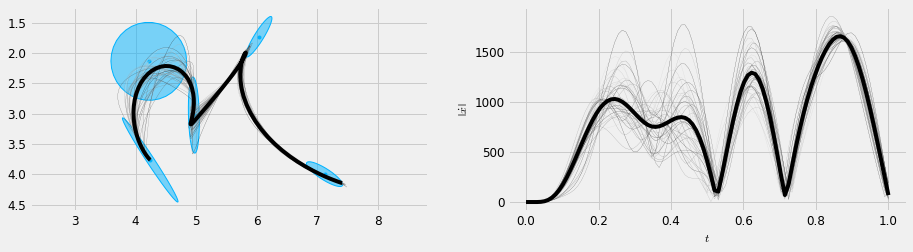

In [61]:
import random
from functools import reduce
np.random.seed(2311)
order = 5

duration = Mu.shape[1]*0.2
sys = DynSys(order, dt=0.01)
n = sys.num_timesteps(duration)
MuQ, Q = make_reference(Mu, Sigma, n, sys, reference=stepwise, end_weight=1e10)
r = SHM_r(d, order, duration, Mu.shape[1])
x, Cov, mse = batch_mpc(sys, MuQ, Q, r=r, compute_covariance=True)

samps = stochastic_sample(x, Cov, mse, 40, 7, sig=2.5)
samps = [sys.y(samp) for samp in samps]
#x = iterative_mpc(sys, MuQ, Q, r=r)

y = sys.y(x)

# time 
T = np.linspace(0, duration, n)
cfg.plan_color = [0.5, 0.5, 0.5]
plt.figure(figsize=(cfg.fig_w*2.0, cfg.fig_h*0.7))
plt.subplot(1, 2, 1)
#plt.title('Trajectory samples')
plot_gauss(Mu, Sigma) # Note this function def is hidden for saving space
#plt.plot(Mu[0,:], Mu[1,:], ':', color=cfg.plan_color)
np.random.seed(32)
rand_grey = lambda: np.ones(3) * np.random.uniform(0.1, 0.9)
for s in samps:
    plt.plot(s[0,:], s[1,:], 'm', label='samples', linewidth=0.2, color=rand_grey() )
plt.plot(y[0,:], y[1,:], 'k', label='mean trajectory')
plt_setup()
#plt.legend()

plt.subplot(1, 2, 2)
#plt.title('Speed')
np.random.seed(32)
for s in samps:
    S = norm(deriv(s*100, sys.dt, 1))
    plt.plot(np.linspace(0, duration, S.size), S, 'm', linewidth=0.2, color=rand_grey())
S = norm(deriv(y*100, sys.dt, 1))
plt.plot(np.linspace(0, duration, S.size), S, 'k')
plt.gca().set_xlabel('$t$')
plt.gca().set_ylabel(r'$\left\| \dot{x} \right\|$')
plt.savefig('stochastic_n.pdf')
plt.show()

And plot some random samples

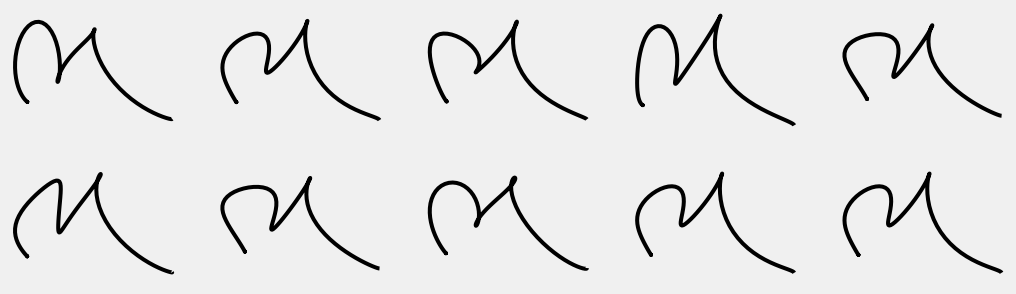

In [62]:
nrows = 2
ncols = 5
n_samps = nrows*ncols
figw = 1.6
plt.figure(figsize=(figw*n_samps, 0.3*figw*n_samps))
random.seed(72)
random.seed(911972)

for i in range(n_samps):
    plt.subplot(nrows, ncols, i+1)
    s = random.choice(samps)
    plt.plot(s[0,:], s[1,:], 'k')
    plt_setup(False)
plt.savefig('stochastic_n_samples.pdf')
plt.show()

## Bezier curve approximation
Gaussians with isotropic covariance can be used for computing approximations of Bezier curves [4].
Lets first define some code to load Bezier paths from a SVG file, using the svgpathtools package.

In [63]:
!pip install svgpathtools
import svgpathtools as svg

def to_pt(c):
    ''' convert complex number to np vector'''
    return np.array([c.real, c.imag])
    
def to_bezier(piece):
    ''' convert a line or Bezier segment to control points'''
    one3d = 1./3
    if type(piece)==svg.path.Line:
        a, b = to_pt(piece.start), to_pt(piece.end)
        return [a, a+(b-a)*one3d, b+(a-b)*one3d, b]
    elif type(piece)==svg.path.CubicBezier:
        return [to_pt(piece.start),
                to_pt(piece.control1),
                to_pt(piece.control2),
                to_pt(piece.end)]
    raise ValueError

def path_to_bezier(path):
    ''' convert SVG path to a Bezier control points'''
    pieces = [to_bezier(piece) for piece in path]
    bezier = [pieces[0][0]] + sum([piece[1:] for piece in pieces],[]) 
    return np.vstack(bezier).T

def svg_to_beziers(path):
    ''' Load Bezier curves from a SVG file'''
    paths, attributes = svg.svg2paths(path) 
    beziers = [path_to_bezier(path) for path in paths]
    return beziers

And some code to sample a piecewise Bezier curve for plotting.



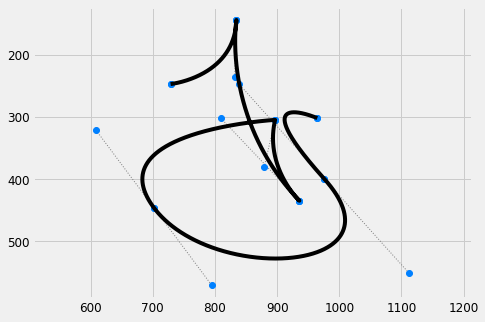

In [65]:
def num_control_points(n_bezier):
    return 1 + 3*n_bezier

def num_bezier(n_ctrl):
    return int((n_ctrl - 1) / 3)

def num_targets(n_ctrl):
    return num_bezier(n_ctrl)-1

def bezier_piecewise(Cp, subd=1000):
    ''' sample a piecewise Bezier curve given a sequence of control points'''
    num = num_bezier(Cp.shape[1]) 
    X = []
    for i in range(num):
        P = Cp[:,i*3:i*3+4].T
        t = np.linspace(0, 1., subd)[:-1].reshape(-1,1)
        t = np.hstack([t, t])
        Y = (1.0-t)**3 * P[0] + 3*(1.0-t)**2 * t * P[1] + 3*(1.0-t)* t**2 * P[2] + t**3 * P[3]
        X += [Y.T] 
    X = np.hstack(X)
    return X

def plot_control_polygon(Cp):
    n_bezier = num_bezier(Cp.shape[1])
    for i in range(n_bezier):
        cp = cp = Cp[:,i*3:i*3+4]
        plt.plot(cp[0,0:2], cp[1,0:2], ':', color=cfg.plan_color, linewidth=1.)
        plt.plot(cp[0,2:], cp[1,2:], ':', color=cfg.plan_color, linewidth=1.)
        plt.plot(cp[0,:], cp[1,:], 'o', color=[0, 0.5, 1.])

Cp = svg_to_beziers('/content/Calligraphic-Trajectories/a.svg')[0]
yb = bezier_piecewise(Cp)

plt.figure(figsize=cfg.figsize)
plot_control_polygon(Cp)
plt.plot(yb[0,:], yb[1,:], 'k')
plt_setup()
plt.show()

It turns out that we can closely imitate the Bezier curve, using MPC and a stepwise reference with isotropic Gaussians. To achieve a similar curve, it is necessary to adjust some parameters, such as the maximum displacement \(d\) and the relative variance of the Gaussians corresponding with internal control points.

This formulation can be useful to interactively edit a trajectory with an interface similar to the one offered by Bezier curves, while guaranteeing a smooth trajectory regardless of the positioning of control points. While this approach may not be ideal for a design oriented application, where a high precision is desirable, it can come handy for applications that require the simulation of a hand-drawn trace, where trajectory smoothness is more important.

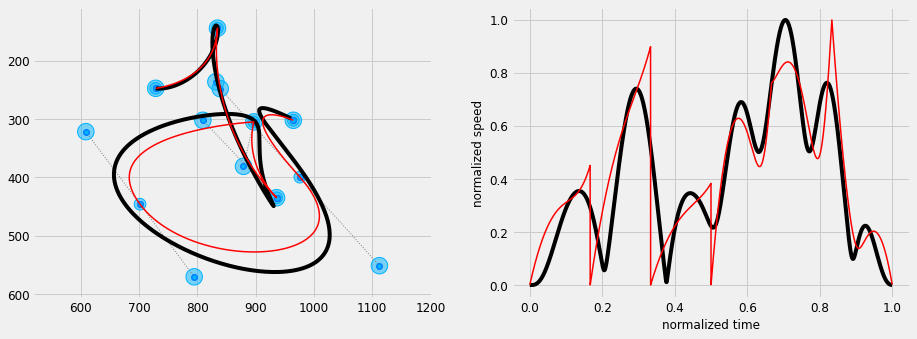

In [66]:
def mpc_bezier_stepwise(Cp, order, ctrl_ratio, max_d, dt=0.005):
    ''' Mimic a Bezier curve with isotropic Gaussians and a stepwise tracking reference''' 
    sys = DynSys(order, dt=dt)

    m = Cp.shape[1]
    
    T = 0.25 * m #1.0*num_bezier(m)
    n = int(T / sys.dt)

    Mu = np.zeros((2,m))
    Sigma = np.zeros((2,2,m))

    for i in range(num_bezier(m)):
        
        p1,p2,p3,p4 = [Cp[:,j+i*3] for j in range(4)]
        
        d = (p1 - p2 + p4 - p3)/2

        dr = 0.0 
        Mu[:,i*3] = p1
        Mu[:,i*3+3] = p4
        Mu[:,i*3+1] = p2 + d*dr #- d1*dr
        Mu[:,i*3+2] =  p3 + d*dr #- d2*dr

        sigma = np.eye(2)
        Sigma[:,:,i*3]   = sigma
        Sigma[:,:,i*3+1] = np.eye(2)*ctrl_ratio
        Sigma[:,:,i*3+2] = np.eye(2)*ctrl_ratio
        Sigma[:,:,i*3+3] = sigma
        
    MuQ, Q = make_reference(Mu, Sigma, n, sys, reference=stepwise, end_weight=1e10)

    r = SHM_r(max_d, order, T, m)
    
    x = iterative_mpc(sys, MuQ, Q, r=r) 
    y = sys.y(x)
    return y, Mu, Sigma

plt.figure(figsize=(cfg.fig_w*2, cfg.fig_h))
# Plot Bezier and MPC overlaid
plt.subplot(1, 2, 1)
plot_control_polygon(Cp)
y, Mu, Sigma = mpc_bezier_stepwise(Cp, 
                                   order=4, 
                                   ctrl_ratio=2.0, 
                                   max_d=0.01)
plot_gauss(Mu, Sigma, scale=100.)
plt.plot(y[0,:], y[1,:], 'k', label='MPC')
plt.plot(yb[0,:], yb[1,:], 'r', linewidth=1.5, label='Bezier')
plt_setup()

plt.subplot(1, 2, 2)
# compute speed and normalize
S = norm(deriv(y, 0.01, 1))
Sb = norm(deriv(yb, 0.01, 1))
S = S/np.max(S)
Sb = Sb/np.max(Sb)
plt.plot(np.linspace(0, 1., S.shape[0]), S, 'k')
plt.plot(np.linspace(0, 1., Sb.shape[0]), Sb, 'r', linewidth=1.5)
plt.gca().set_xlabel('normalized time')
plt.gca().set_ylabel('normalized speed')
plt.show()

## Interpolation with MPC
The same optimisation method can be used to generate interpolating trajectories (passing through via-points). To do so, we define a sparse reference, in which a desired state in only specified in correspondence with its desired time step. For the case in which the time occurrence of the states is equally spaced in time we can define a new reference function:

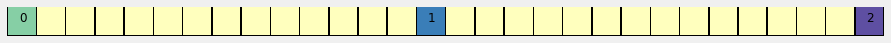

In [67]:
def via_points(m, n):
    ''' Get via-point reference indices
    returns target indices, and corresponding time steps in reference for each index'''
    a, b = 0., n-1
    return range(m), [ int(a + i*(b-a)/(m-1)) for i in range(m) ]

# For 30 time steps and 3 via points:
Ts = -np.ones(30).astype(int)
I, T = via_points(3, 30)
Ts[T] = I

plt.figure(figsize=(14,0.5))
plt.gca().pcolormesh([[ float(t)/3+0.5 if t >= 0 else 0 for t in Ts]], cmap='Spectral', edgecolor='k', vmin=-1., vmax=1.)
for i, t in enumerate(Ts):
    if t >= 0:
        plt.text(0.4 + i, 0.5,str(t))
plt.axis('off')
plt.show()

We then express the penality of deviating from a desired state with an indentity covariance matrix, which corresponds to a cost given by the Euclidean distance to a target.

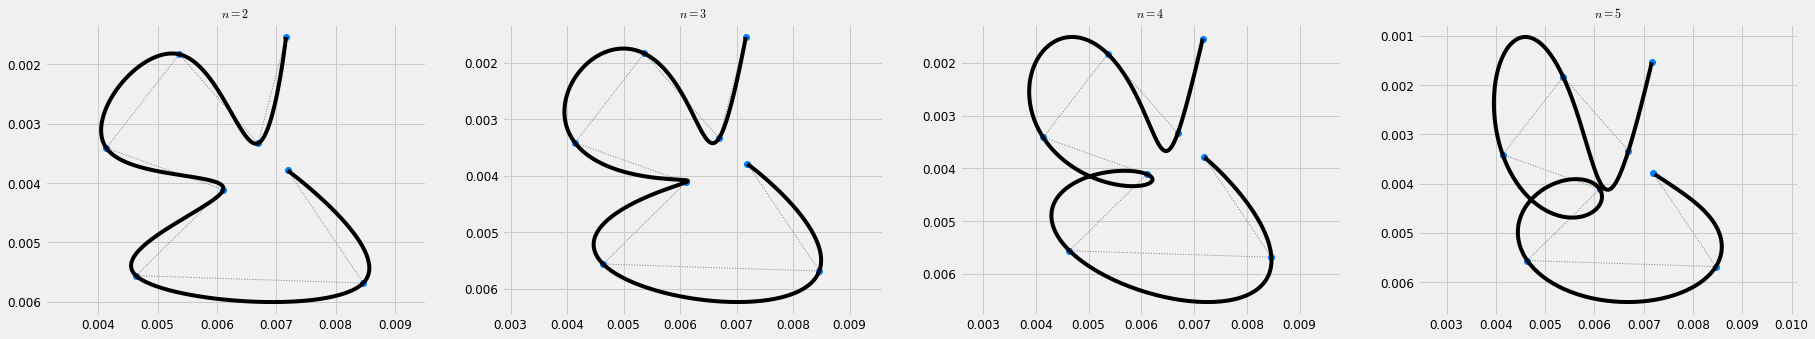

In [69]:
def load_and_interpolate(path, order, stroke_duration=0.3, scale=1./100000):
    Mu, Sigma = load_gauss(path, scale=scale) 
    duration = Mu.shape[1]*stroke_duration
    sys = DynSys(order, dt=0.005)
    n = sys.num_timesteps(duration)
    
    endw = 1.
    r = 1e-10

    MuQ, Q = make_reference(Mu, Sigma, n, sys, reference=via_points, end_weight=endw) #1e-15) #0.)
    x = iterative_mpc(sys, MuQ, Q, r=r)
    
    return Mu, Sigma, sys.y(x) 
    
dt = 0.005
orders = range(2,6)

plt.figure(figsize=(cfg.fig_w*len(orders), cfg.fig_h))
for i,order in enumerate(orders):
    plt.subplot(1, len(orders), i+1)
    plt.title('$n=' + str(order) + '$')
    Mu, Sigma, x = load_and_interpolate('/content/Calligraphic-Trajectories/e.pkl', order)
    plt.plot(Mu[0,:], Mu[1,:], ':', color=cfg.plan_color, linewidth=1.)
    plt.plot(Mu[0,:], Mu[1,:], 'o', color=[0,0.5,1.], linewidth=1.)
    plt.plot(x[0,:], x[1,:], 'k')
    plt_setup()

plt.show()

The MJ ("minimum jerk")trajectory has a closed form solution given by a polynomial of order \(5\), which can be computed with the following function



In [70]:
def min_jerk_via( x0,x1,xf, t, t1, tf ):
    tau1 = t1 / tf
    tau = t / tf
    tf5 = tf**5
    ta2 = tau**2 
    ta3 = tau**3
    ta4 = tau**4
    ta5 = tau**5
    ta1_2 = tau1**2 
    ta1_3 = tau1**3
    ta1_4 = tau1**4
    ta1_5 = tau1**5
    
    c = ( (1 / (tf5*ta1_2*(1 - tau1)**5)) * ((xf - x0)*(300.*ta1_5 - 1200.*ta1_4 + 1600.*ta1_3)
        + ta1_2*(-720.*xf + 120.*x1 + 600.*x0) 
            + (x0 - x1)*(300*tau1 - 200)))
    
    p = ( (1 / (tf5*ta1_5*(1 - tau1)**5)) * ((xf - x0)*(120*ta1_5 
            - 300.*ta1_4 + 200.*ta1_3) - 20*(x1 - x0)))
            
    x = ((tf5/720.) * (p*(ta1_4*(15.*ta4 - 30.*ta3) 
    + ta1_3*(80.*ta3 - 30.*ta4) - 60.*ta3*ta1_2 + 30.*ta4*tau1 - 6.*ta5)
                  + c*(15.*ta4 - 10.*ta3 - 6.*ta5)) + x0)
    if t > t1:
        x = x + p * ( tf5 * (tau - tau1)**5 ) / 120.
    return x

The time occurrence of the via point is given by the real root of a \(9\mathrm{th}\) order polynomial, which we use SymPy to compute

In [71]:
import sympy as sym
def solve_tau1(X):
    vals = sym.symbols('x_0, y_0, x_1, y_1, x_f, y_f', real=True)
    x_0, y_0, x_1, y_1, x_f, y_f = vals
    v = [X[0,0], X[1,0], X[0,1], X[1,1], X[0,2], X[1,2]]
    tau_1 = sym.symbols('tau_1', real=True)
    # quite a beast...
    poly = 6*tau_1**9*x_0**2 - 12*tau_1**9*x_0*x_f + 6*tau_1**9*x_f**2 + 6*tau_1**9*y_0**2 \
           - 12*tau_1**9*y_0*y_f + 6*tau_1**9*y_f**2 - 27*tau_1**8*x_0**2 + 54*tau_1**8*x_0*x_f \
           - 27*tau_1**8*x_f**2 - 27*tau_1**8*y_0**2 + 54*tau_1**8*y_0*y_f - 27*tau_1**8*y_f**2 \
           + 40*tau_1**7*x_0**2 - 80*tau_1**7*x_0*x_f + 40*tau_1**7*x_f**2 + 40*tau_1**7*y_0**2 \
           - 80*tau_1**7*y_0*y_f + 40*tau_1**7*y_f**2 - 8*tau_1**6*x_0**2 - 12*tau_1**6*x_0*x_1 \
           + 28*tau_1**6*x_0*x_f + 12*tau_1**6*x_1*x_f - 20*tau_1**6*x_f**2 - 8*tau_1**6*y_0**2 \
           - 12*tau_1**6*y_0*y_1 + 28*tau_1**6*y_0*y_f + 12*tau_1**6*y_1*y_f - 20*tau_1**6*y_f**2 \
           - 36*tau_1**5*x_0**2 + 36*tau_1**5*x_0*x_1 + 36*tau_1**5*x_0*x_f - 36*tau_1**5*x_1*x_f \
           - 36*tau_1**5*y_0**2 + 36*tau_1**5*y_0*y_1 + 36*tau_1**5*y_0*y_f - 36*tau_1**5*y_1*y_f \
           + 34*tau_1**4*x_0**2 - 34*tau_1**4*x_0*x_1 - 34*tau_1**4*x_0*x_f + 34*tau_1**4*x_1*x_f \
           + 34*tau_1**4*y_0**2 - 34*tau_1**4*y_0*y_1 - 34*tau_1**4*y_0*y_f + 34*tau_1**4*y_1*y_f \
           - 8*tau_1**3*x_0**2 + 8*tau_1**3*x_0*x_1 + 8*tau_1**3*x_0*x_f - 8*tau_1**3*x_1*x_f \
           - 8*tau_1**3*y_0**2 + 8*tau_1**3*y_0*y_1 + 8*tau_1**3*y_0*y_f - 8*tau_1**3*y_1*y_f \
           - 2*tau_1*x_0**2 + 4*tau_1*x_0*x_1 - 2*tau_1*x_1**2 - 2*tau_1*y_0**2 + 4*tau_1*y_0*y_1 \
           - 2*tau_1*y_1**2 + x_0**2 - 2*x_0*x_1 + x_1**2 + y_0**2 - 2*y_0*y_1 + y_1**2
    eval_poly = poly.subs(dict(zip(vals,v)))
    expr = (sym.expand(eval_poly.as_expr()))
    realroot = sym.nsolve(expr, 0.5) 
    return float(realroot)

def via_points_tau1(m, n, tau_1):
    ''' Get via-point reference indices
    returns target indices, and corresponding time steps in reference for each index'''
    a, b = 0., n-1
    I = range(m)
    t1_n = int(tau_1*n)
    T = [0, t1_n, n-1]
    return I, T #range(m), [ int(a + i*(b-a)/(m-1)) for i in range(m) ]

We then can compare the MPC solution to the original closed form solution



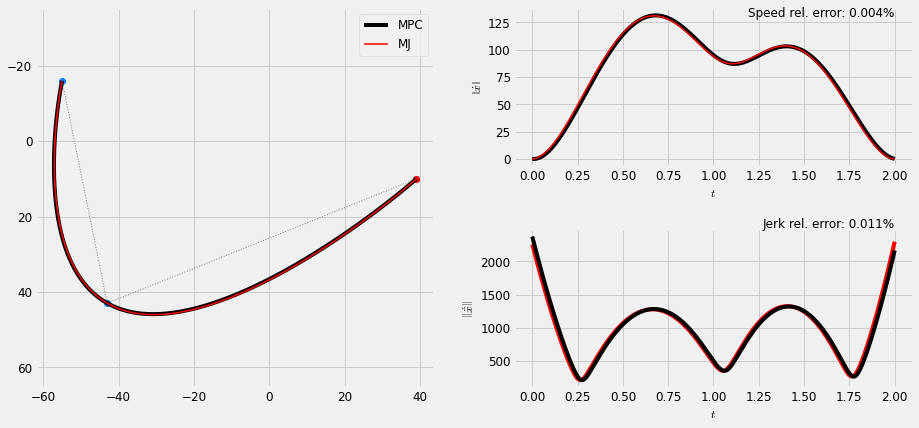

In [72]:
def rel_err(x, x_hat):
    '''Relative error [0-1]'''
    e = (np.sum(np.abs(x-x_hat)) / np.sum(x_hat)) / len(x_hat)
    return e


sys = DynSys(3, 0.005)
duration = 2.
n = sys.num_timesteps(duration)

# MPC trajectory
plt.rc('text', usetex = False)
m = 3
np.random.seed(123)
Mu = np.floor(np.random.uniform(-100, 100, size=(2, m)))
Sigma = np.dstack([np.eye(2,2) for i in range(m)])

# Solve for via point relative time
tau_1 = solve_tau1(Mu)

MuQ, Q = make_reference(Mu, Sigma, n, sys, reference=lambda m,n: via_points_tau1(m, n, tau_1), end_weight=1.)
x = iterative_mpc(sys, MuQ, Q, r=1e-10)
y = sys.y(x)

# time steps
T = np.linspace(0, duration, n)

# Minimum jerk trajectory
yj = np.array([ min_jerk_via(Mu[:,0], Mu[:,1], Mu[:,2], t, tau_1*duration, duration) for t in T]).T

plt.figure(figsize=(cfg.fig_w*2, 1.3*cfg.fig_h)) #(15,5))
vmargin = 0.4
plt.subplots_adjust(hspace=vmargin) #, top=vmargin+2.)
plt.subplot2grid((2, 2), (0,0), rowspan=2)
plt.plot(Mu[0,:], Mu[1,:], ':', color=cfg.plan_color, linewidth=1.)
plt.plot(Mu[0,:], Mu[1,:], 'o', color=[0,0.5,1.])
plt.plot(Mu[0,0:1], Mu[1,0:1], 'ro') #, color=[0,0.5,1.])
plt.plot(y[0,:], y[1,:], 'k', label='MPC')
plt.plot(yj[0,:], yj[1,:], 'r', label='MJ', linewidth=1.5)

plt_setup()
plt.legend()

# Speed error
plt.subplot2grid((2, 2), (0,1))
#plt.title('Speed')
S = norm(deriv(y, sys.dt, 1))
Sj = norm(deriv(yj, sys.dt, 1))
# size hack for time
T = np.linspace(0, duration, len(Sj))
err = rel_err(S, Sj)
errstr = ('%.3f'%(err*100)) + '%'
plt.plot(T, S, 'k')
plt.plot(T, Sj, 'r', linewidth=1.5)
plt.text(2.0, 130, 'Speed rel. error: ' + errstr, horizontalalignment='right')
plt.gca().set_xlabel('$t$')
plt.gca().set_ylabel(r'$\left\| \dot{x} \right\|$')

# Jerk error
plt.subplot2grid((2, 2), (1,1))
#plt.title('Jerk')
S = norm(deriv(y, sys.dt, 3))[1:]
Sj = norm(deriv(yj, sys.dt, 3))[1:]
# size hack for time
T = np.linspace(0, duration, len(Sj))
err = rel_err(S, Sj)
errstr = ('%.3f'%(err*100)) + '%'
plt.plot(T, Sj, 'r')
plt.plot(T, S, 'k')
plt.text(2., 2500.0, 'Jerk rel. error: ' + errstr, horizontalalignment='right')
plt.gca().set_xlabel(r'$t$')
plt.gca().set_ylabel(r'$\left\| \dot\ddot{x} \right\|$')

# Save and show
plt.savefig('mj.pdf')
plt.show()


## Stylisation and Semi-tied Gaussians
f we look at the proposed optimal control formulation of trajectories for the case of letter forms, we can consider different stylisations of a letter with a bi level representation, in which the sequence of targets defines an overall structure, and different trajectories that follow Gaussians placed in correspondence with the targets define different stylisations of the same structure. This representation is similar to the one proposed by semiotician William C. Watt [Watt1988]. Watt used formal grammars to study the evolution of written letters in history through two complemtary descriptors: one iconic that describes the letter form as a symbol, and one kinemic that describes the movements used to produce the letter when writing. We can exploit a similar framework to generate different stylisation of letters defined as sparse sequneces of targets.

As an example we can take the target description of a letter "N". We can for example generate different stylisations of the letter by varying the maximum displacement parameter \(d\), where a lower value of \(d\) will produce smoother trajectories. Watt calls this process "facilitation", i.e. the tendency to produce a letter form with a reduced effort, whic results in smoother traces.

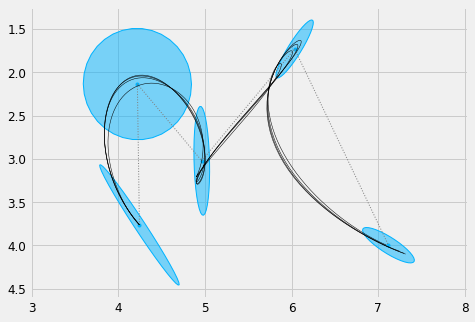

In [74]:
Mu, Sigma = load_gauss('/content/Calligraphic-Trajectories/m_1.pkl', scale=0.01) 

order = 5
duration = Mu.shape[1]*0.2 # 0.2 seconds per state
sys = DynSys(order, dt=0.005)
n = sys.num_timesteps(duration)
endw = 1e10

plt.figure(figsize=cfg.figsize)
plot_gauss(Mu, Sigma)
plt.plot(Mu[0,:], Mu[1,:], ':', color=cfg.plan_color, linewidth=1.)

for d in np.linspace(0.2, 0.6, 4):
  r = SHM_r(d, order, duration, Mu.shape[1])
  MuQ, Q = make_reference(Mu, Sigma, n, sys, reference=stepwise, end_weight=1e10) #1e-15) #0.)
  x = iterative_mpc(sys, MuQ, Q, r=r)
  y = sys.y(x)
  plt.plot(y[0,:], y[1,:], 'k', linewidth=0.5)
plt_setup()
plt.show()

Other stylistic variations can be produced by varying other parameters, such as the orientation and scale of the covariances corresponding with each target. If we try to randomly generate covariances for each target, we can see that this process may be actually hard to control and often produce unpredictable results:

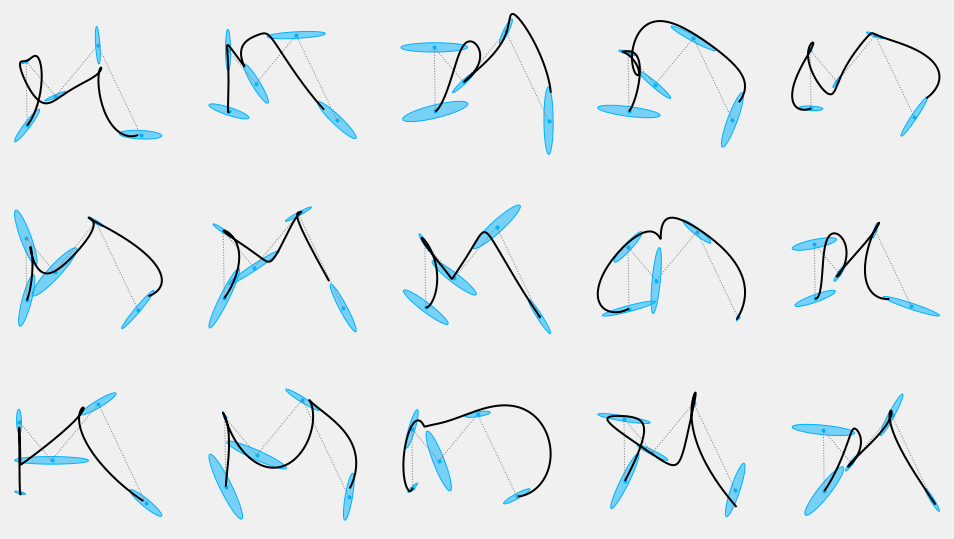

In [75]:
def make_sigma(theta, scale):
    ''' Builds a 2d covariance with a rotation and scale'''
    scale=np.array(scale)
    
    # rotation matrix
    Phi = np.eye(2, 2)
    ct = np.cos(theta)
    st = np.sin(theta)
    Phi[0,0], Phi[0,1] = ct, -st
    Phi[1,0], Phi[1,1] = st, ct
    
    # scale matrix
    S = np.diag(scale*scale) 
    return mul([Phi, S, Phi.T])

# Fix the seed for demonstration purposes
np.random.seed(326)
n_rows = 3
n_cols = 5
nsamples = n_rows*n_cols
plt.figure(figsize=(3*n_cols, 3*n_rows))

for i in range(nsamples):
    plt.subplot(n_rows, n_cols, i+1)
    Sigma2 = np.array(Sigma)
    for j in range(Mu.shape[1]):
        s = np.random.uniform(0.1, 0.9)
        Sigma2[:,:,j] = make_sigma(np.random.uniform(-np.pi, np.pi),
                                    [s, s*np.random.uniform(0.1, 0.2)]) #np.random.uniform(0.02, 0.5, 2))

    plot_gauss(Mu, Sigma2)
    plt.plot(Mu[0,:], Mu[1,:], ':', color=cfg.plan_color, linewidth=1.)

    r = SHM_r(0.3, order, duration, Mu.shape[1])
    MuQ, Q = make_reference(Mu, Sigma2, n, sys, reference=stepwise, end_weight=1e10) #1e-15) #0.)
    x = iterative_mpc(sys, MuQ, Q, r=r)
    y = sys.y(x)
    plt.plot(y[0,:], y[1,:], 'k', linewidth=2)
    plt_setup(axis=False)
plt.show()

One way to overcome this problem and maintain a greater control over the results, is to force a shared orientation for all the covariance ellipsoids

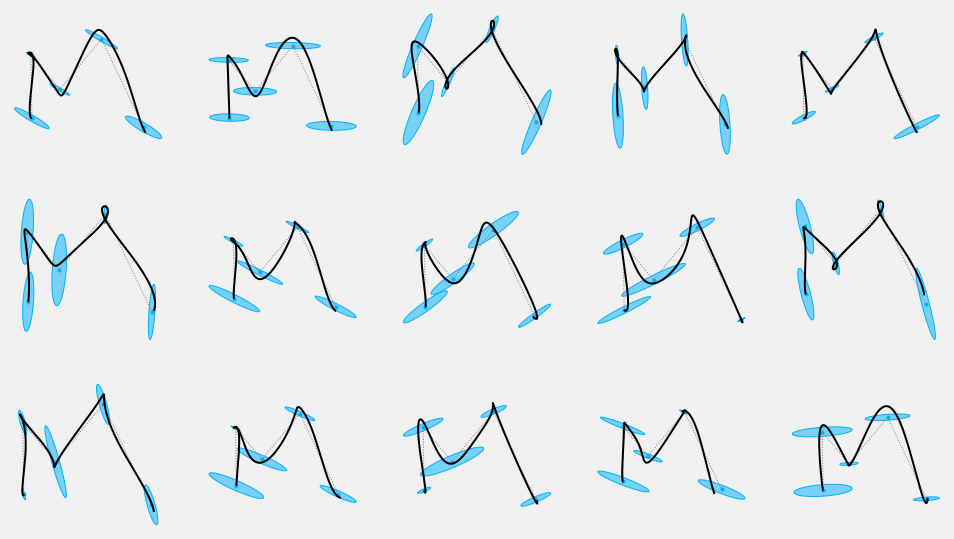

In [76]:
n_rows = 3
n_cols = 5
nsamples = n_rows*n_cols
plt.figure(figsize=(3*n_cols, 3*n_rows))
Theta = np.random.uniform(-np.pi, np.pi, nsamples)
np.random.seed(326)
for i in range(nsamples):
    plt.subplot(n_rows, n_cols, i+1)
    Sigma2 = np.array(Sigma)
    
    for j in range(Mu.shape[1]):
        s = np.random.uniform(0.1, 0.9)
        np.random.uniform(-np.pi, np.pi) # Just to keep the same seed
        Sigma2[:,:,j] = make_sigma(Theta[i],
                                   [s, s*np.random.uniform(0.1, 0.2)]) #np.random.uniform(0.02, 0.5, 2))

    plot_gauss(Mu, Sigma2)
    plt.plot(Mu[0,:], Mu[1,:], ':', color=cfg.plan_color, linewidth=1.)

    r = SHM_r(0.3, order, duration, Mu.shape[1])
    MuQ, Q = make_reference(Mu, Sigma2, n, sys, reference=stepwise, end_weight=1e10) #1e-15) #0.)
    x = iterative_mpc(sys, MuQ, Q, r=r)
    y = sys.y(x)
    plt.plot(y[0,:], y[1,:], 'k', linewidth=2)
    plt_setup(axis=False)
plt.show()